### 교수님 처음 만들었던 linear_cpu_data 코드가 지금 이 문제에 맞는것 같고, 변경을 어떻게 해야하나 잘 모르겠습니다. 강의 자료와 예제를 계속 비교해봤지만 이해가 되지 않는 부분이 많아서 앞서 만든 코드와 동일하게 이 소스파일을 작성하게 되었습니다. 발전하지 못한 모습 보여서 죄송합니다

## I. 문제 정의
* 데이터 셋 “machine.data.csv ” 기반으로 CPU 성능에 관련된 다양한 특징들을 이용하여 CPU의 성능을 예측하는 회귀 분석 모델링하시오. 

## II. 데이터 셋 소개 및 지도학습의 타겟 변수 정의 
* 다음 주어진 데이터 셋 “machine.data.csv”은 “UC Irvine Machine Learning Repository”에서 제공하는 CPU 성능과 관련된 다양한 특징(features, variables)을 포함하고 있다. 이 데이터 셋는 9개의 특징을 가지는 209개의 샘플로 구성되어 있다. 9개의 특징은 다음과 같은 변수 표 정보를 요약할 수 있다. 이 데이터 셋은 CPU의 다양한 기술적 특징과 성능을 포함하여 데이터분석 및 비교를 용이하게 해준다. 
* 데이터 셋 출처 URL : https://archive.ics.uci.edu/dataset/29/computer+hardware
* 타겟 변수 : PRP는 “실제 발표된 CPU 성능”을 나타내어, 성능 예측 모델의 정확성을 평가하는 데 지도학습의 목표값으로 사용한다.

## (1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
* 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

In [1]:
#지금까지 사용했던 모든 API 임포트 및 준비
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

    VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry         Aug-80   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]
Index(['VendorName', 'Model

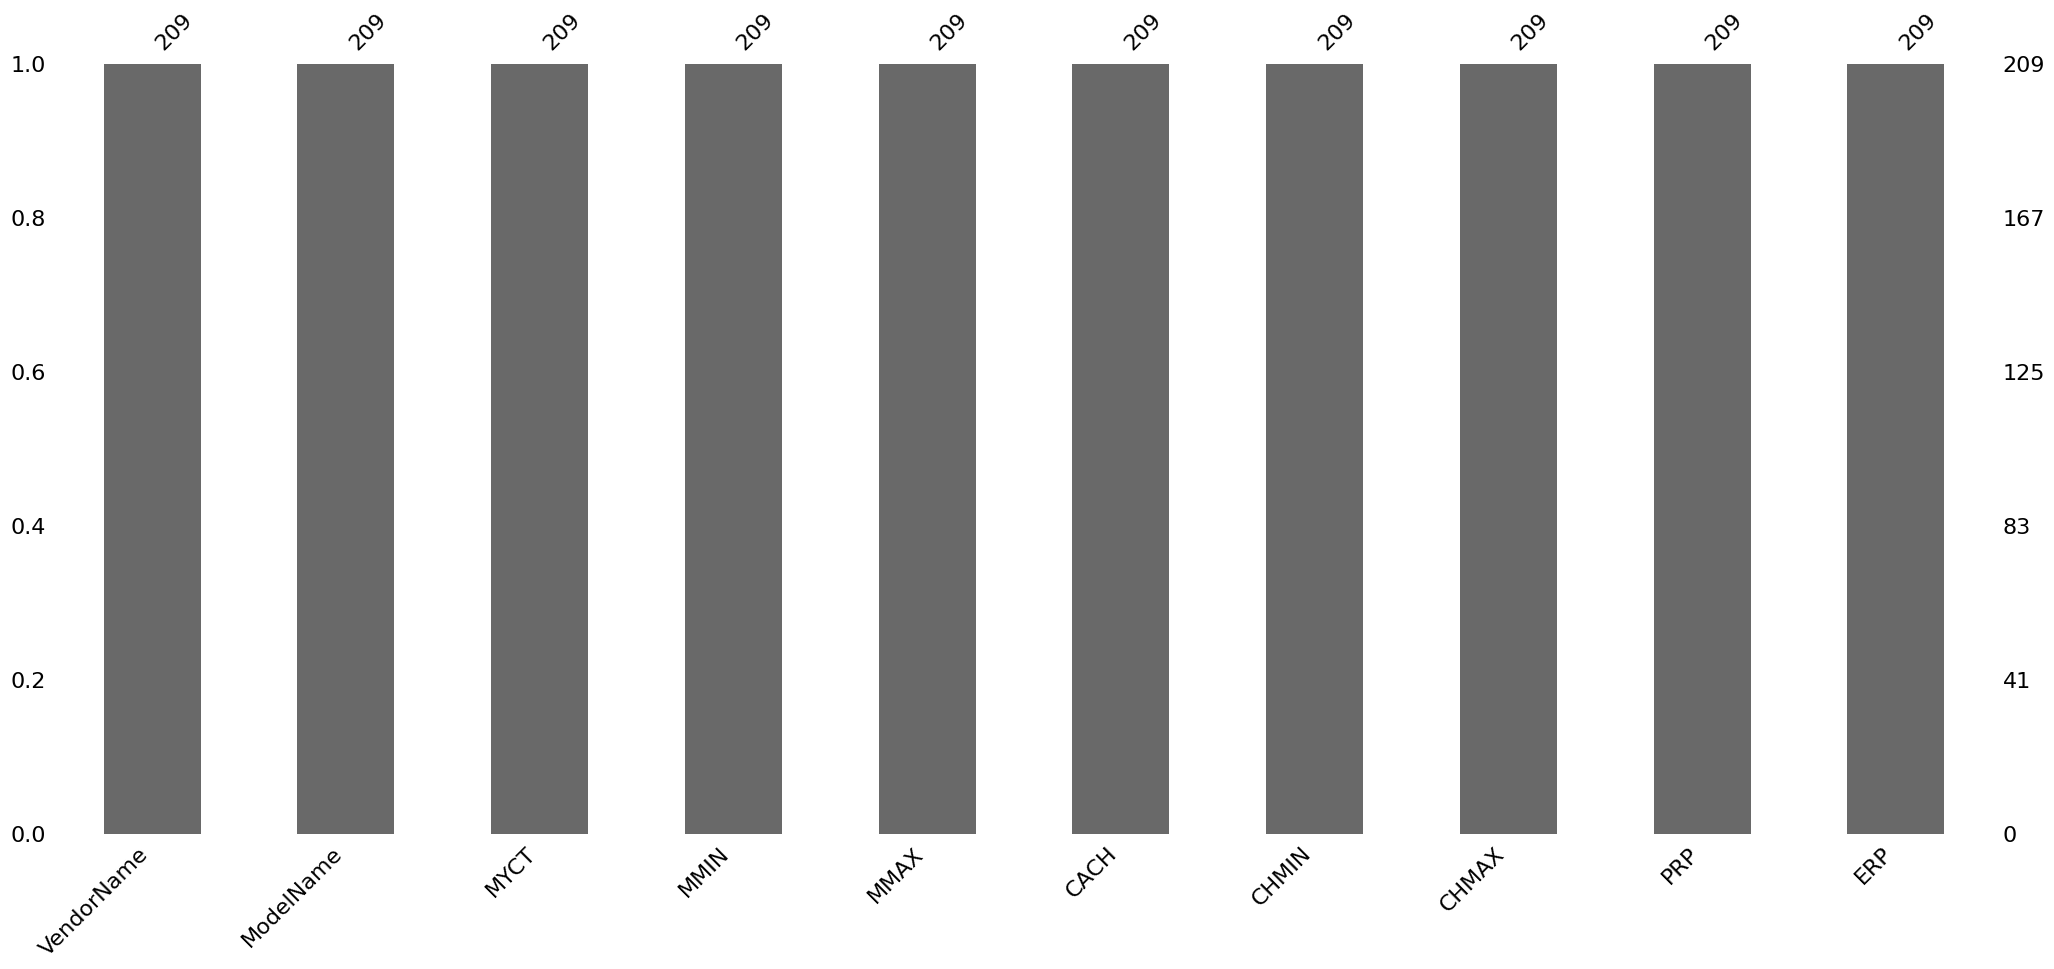

In [2]:
#데이터 탐색                                                   리니어리그리션의 기본에 대한것이다 4차는 3차의 모델을 가지고 성능분석을 했더니 성능평가 지표값이 좋게나오는데 파이프라인 구조를 이용하여 하이퍼 파라메타 튜닝을 해서 다른 방식으로 예측기를 만들고 리니어리그리션하고 비교
df_PRP = pd.read_csv("machine.data_update.csv")  # 데이터 로드           리니어리그리션 해가지고 파이프라인 해가지고, 
print(df_PRP)                             # 데이터 확인
print(df_PRP.columns)                     # 데이터 칼럼 확인

#데이터 결측치 확인
print(df_PRP.isna().sum())                # 데이터 결측치 없음

#데이터 중복 확인
print(df_PRP.duplicated().sum())          # 데이터 중복 없음

#데이터 시각화
msn.bar(df_PRP)                           # 데이터 시각화

#범주형 데이터 수치화
dum = pd.get_dummies(df_PRP.VendorName, prefix='v', dtype=float)
df_PRP = pd.concat([df_PRP.drop('VendorName', axis=1), dum], axis =1)

dum = pd.get_dummies(df_PRP.ModelName, prefix='ㅡ', dtype=float)
df_PRP = pd.concat([df_PRP.drop('ModelName', axis=1), dum], axis =1)

# 상관계수 값을 양의 상관계수로 처리
result = df_PRP.corr()['PRP']
result = np.abs(result)

#데이터 'PRP'상관관계 분석
# 상관관계 행렬 계산
correlation_matrix = df_PRP.corr()

# 타겟 변수(PRP)와 다른 변수들 간의 상관관계
print(correlation_matrix['PRP'].sort_values(ascending=False))


In [3]:
## 데이터 스케일링
# 1) X : 연속형 변수와 범주형 변수 구분
PRP_features = ['ERP', 'MMAX', 'MMIN','CACH']

#전처리 파이프라인 설정
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers =[('num', numeric_transformer, PRP_features)])

#입력 변수(X)와 타겟 변수(y) 분리 
X = df_PRP[PRP_features]  #상관관계가 높은 칼럼 선택
y = df_PRP['PRP']

In [4]:
##데이터 전처리
#훈련 데이터, 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 개별 모델 정의
models = [('lr', LinearRegression()), ('sgd', SGDRegressor())]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators = models)

# 모델 파이프라인 설정
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha' : [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter' : [1000, 2000, 3000]
}

#GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train,y_train)

#훈련 데이터 학습
model = LinearRegression()                 #LinearRegression 모델 학습
model.fit(X_train, y_train)
print(model)

#데이터 교차검증
best_model = grid_search.best_estimator_   # 최적 모델로 예측
y_pred = best_model.predict(X_test)
                                           # 학습 데이터 vs 테스트 오차 비교
cv_score = cross_val_score(best_model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') 
cv_mse = - cv_score.mean()
print(f"Cross_Validated MSE: {cv_mse}")

train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
print(f"Training MSE : {train_mse}")

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Testing MSE: {test_mse}')


LinearRegression()
Cross_Validated MSE: 2346.1273321483172
Training MSE : 1625.6667497145665
Testing MSE: 2005.780306943029


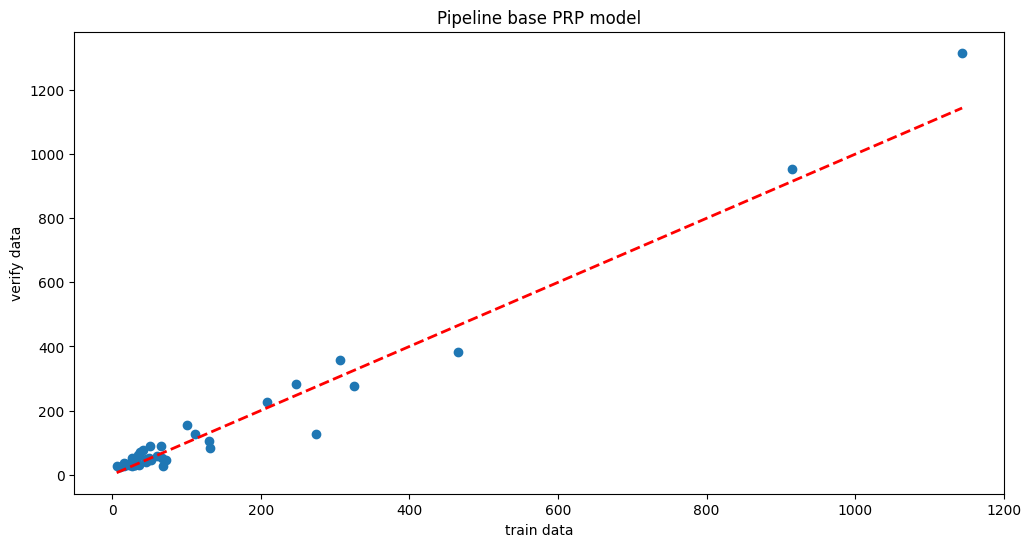

In [5]:
#데이터 분석결과 시각화
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("train data")
plt.ylabel("verify data")
plt.title("Pipeline base PRP model")
plt.show()

## 2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
* Mean squared Error, Mean absolute Error, R^2, 교차검증

In [6]:
#Mean squared Error 검증
mse = mean_squared_error(y_test, y_pred)

#Mean absolute Error 검증
mae = mean_absolute_error(y_test, y_pred)

#R^2 검증
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")

MSE: 2005.780306943029, MAE:28.63872877407475, R^2:0.9605990120806821


## (3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

In [8]:
# 문제 부분을 찾지 못해 죄송합니다.

## (4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.